# Рекомендательная система для онлайн-кинотеатра

Рекомендательная система для онлайн кинотеатра - инструмент, который помогает пользователям находить фильмы, которые им могут понравиться. Такие системы работают на основе алгоритмов, которые анализируют данные о пользователе, такие как его история просмотров, оценки, предпочтения и т.д., и предлагают фильмы или сериалы, которые могут быть интересны.

Рекомендательные системы могут быть полезны для онлайн кинотеатров, так как они помогают пользователям находить фильмы, которые они могут пропустить. Это может увеличить время, проведенное на сайте, и улучшить пользовательский опыт. Также система может помочь кинотеатру повысить доходы, предлагая пользователям фильмы, которые они могут купить или арендовать.

Рекомендательная система для онлайн кинотеатра - это важный инструмент, который может помочь пользователям находить интересные фильмы и улучшить пользовательский опыт онлайн кинотеатра.

**Задача:**

Создать рекомендательную систему для онлайн-кинотеатра с помощью **коллаборативной системы**.

_Коллаборативная система - метод рекомендательных систем, который использует данные о предпочтениях нескольких пользователей для предоставления рекомендаций. В этом методе система анализирует историю просмотров и оценки нескольких пользователей, чтобы определить, какие фильмы или товары могут быть интересны данному пользователю. Этот метод основывается на предположении, что если два пользователя имеют схожие предпочтения, то им понравятся похожие вещи. Коллаборативная система может быть реализована как на основе сходства пользователей, так и на основе сходства объектов._

Для построения рекомендательной системы использую открытый набор данных о рейтинге фильмов MovieLens Latest Datasets. В этом датасете, в частности, содержатся названия фильмов (файл movies.csv) и оценки, которые фильмам ставили зрители (файл rating.csv).

## Подготовка данных

In [36]:
import pandas as pd
import numpy as np
import warnings
np.warnings = warnings

import sweetviz as sv

from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors

In [37]:
def sv_info_df(df):
    report = sv.analyze(df)
    report.show_notebook()

Импортирую данные

In [38]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

Посмотрим на отчеты по данным

                                             |          | [  0%]   00:00 -> (? left)


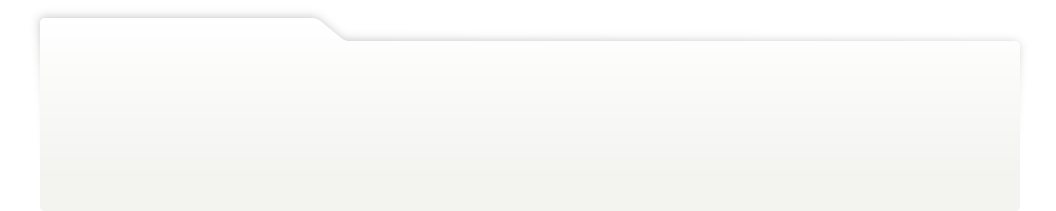
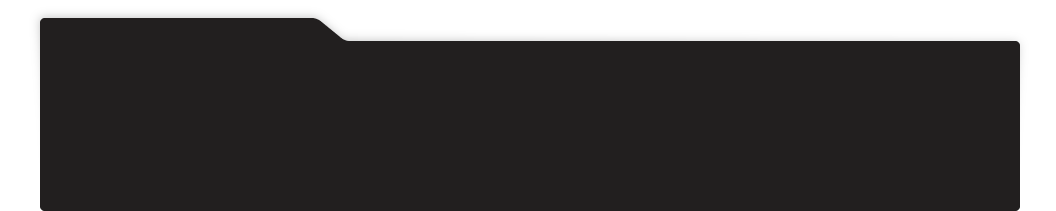
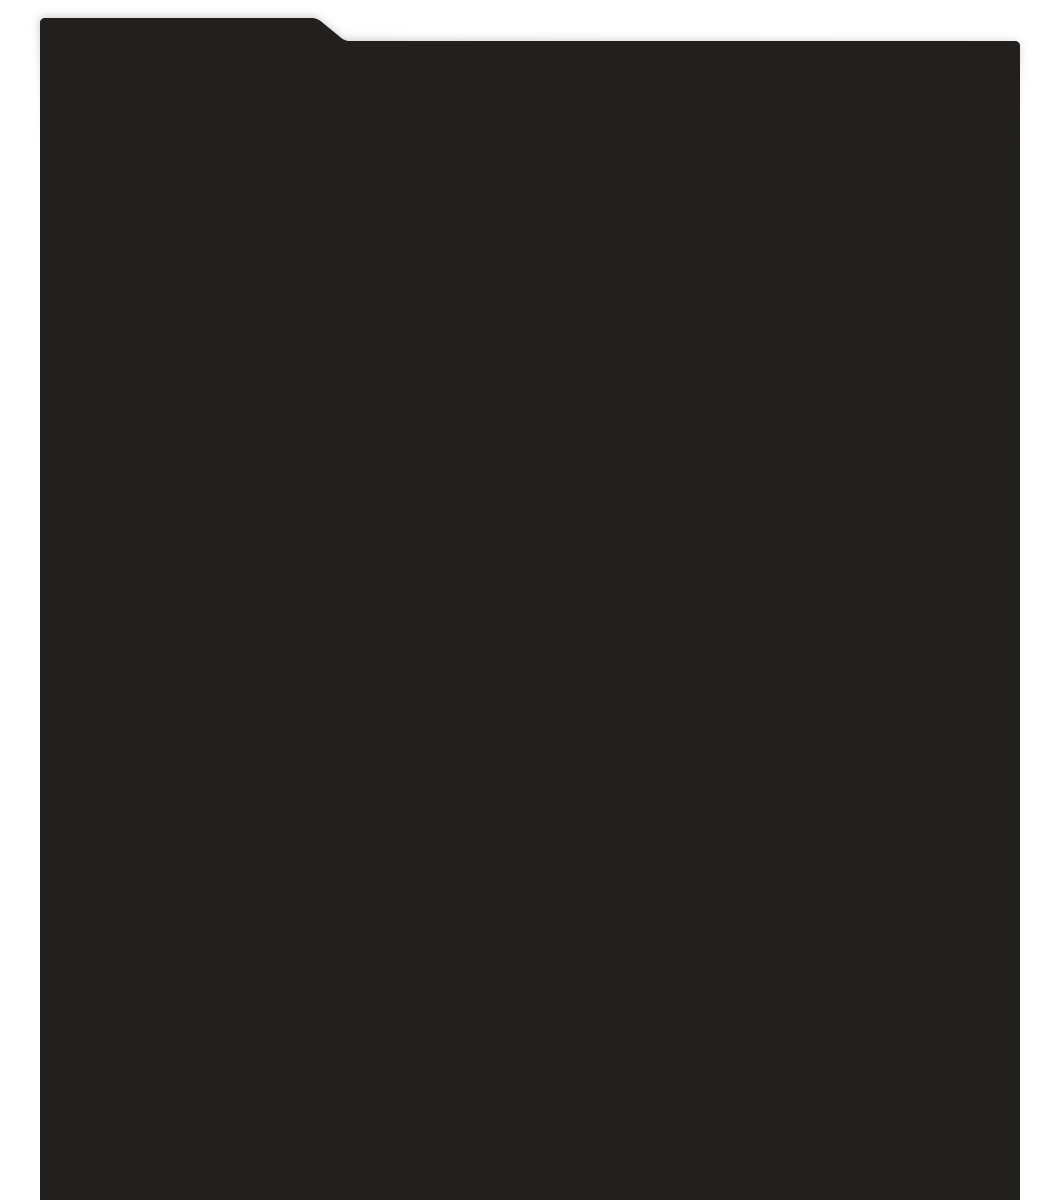
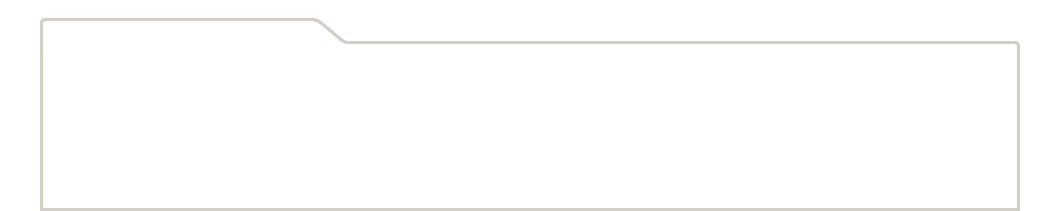
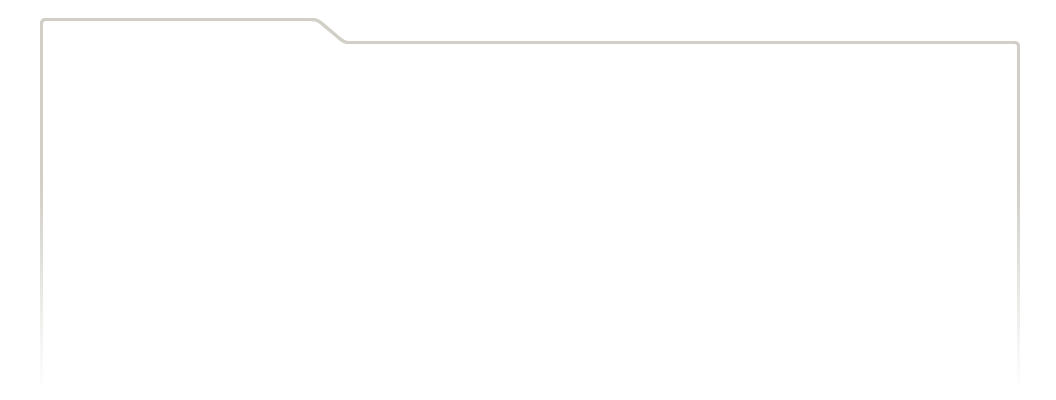
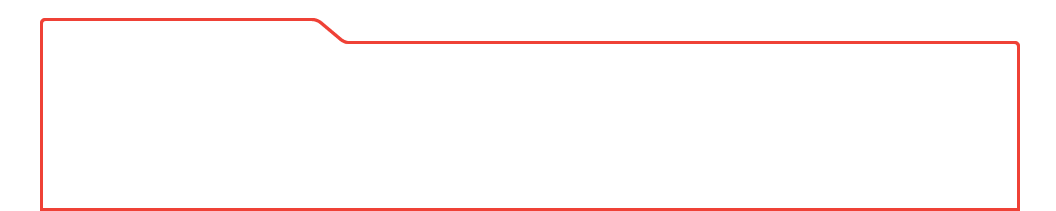
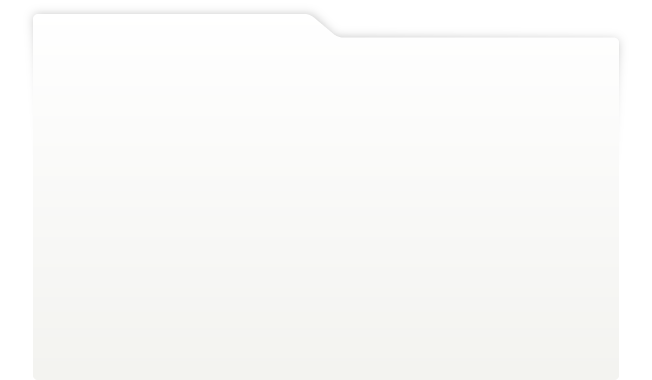
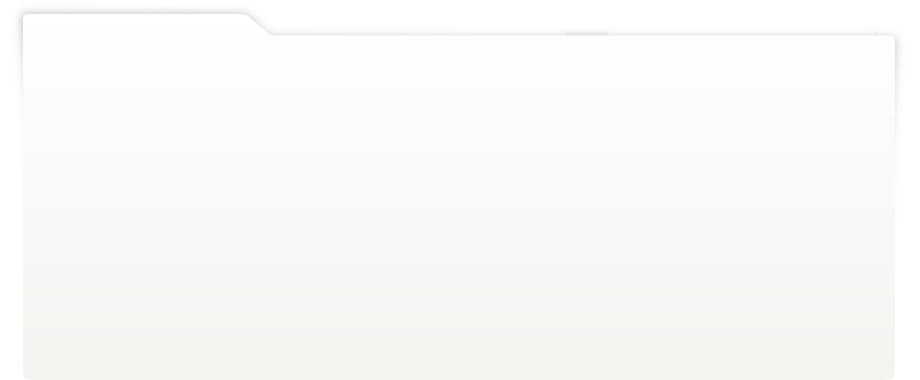
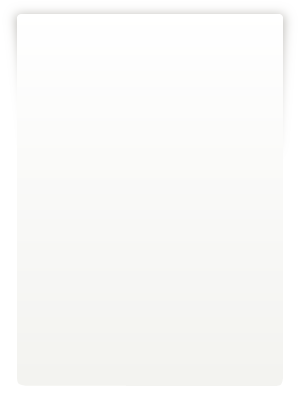
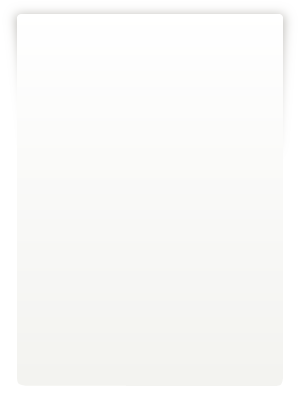
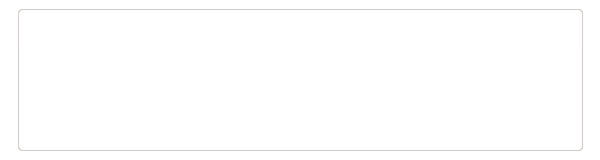
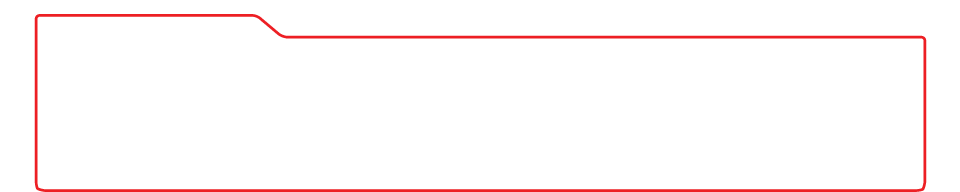
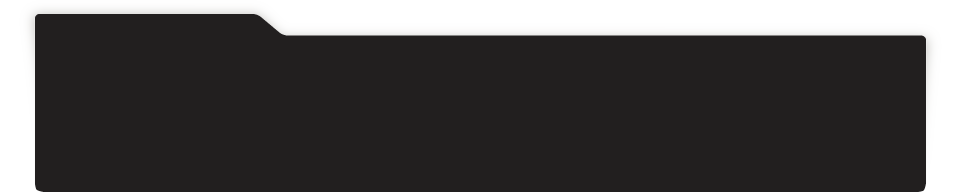
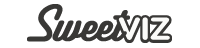
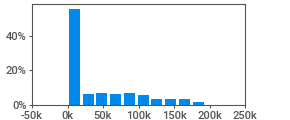
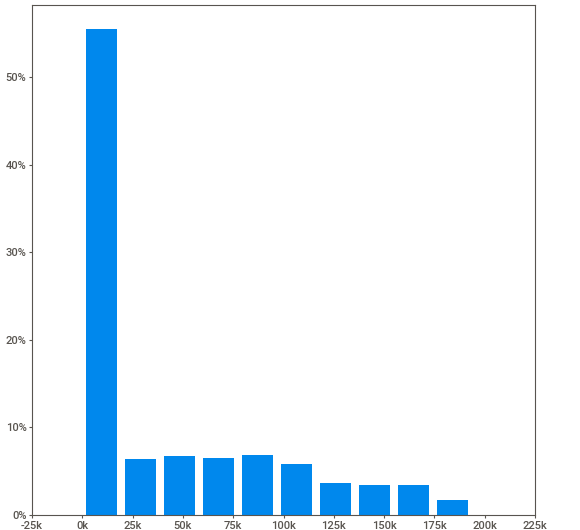
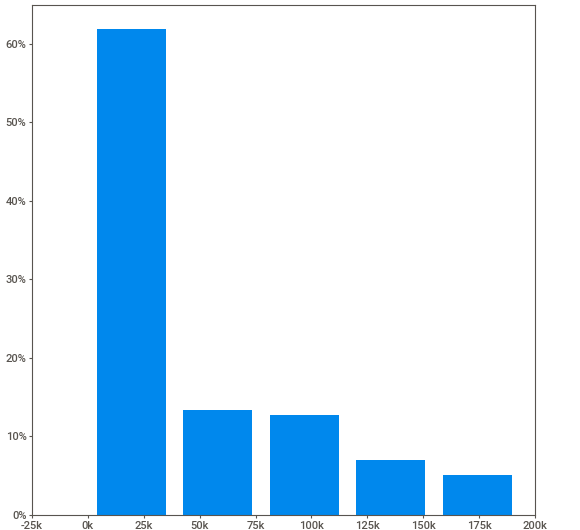
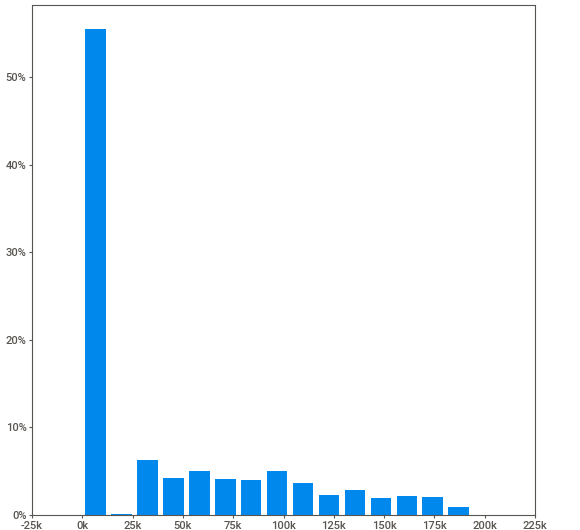
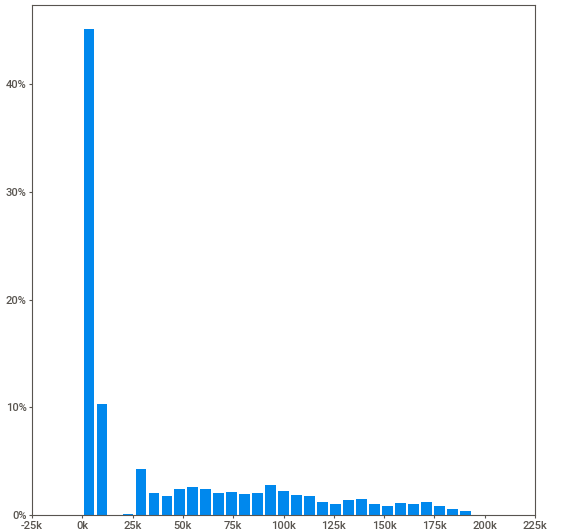
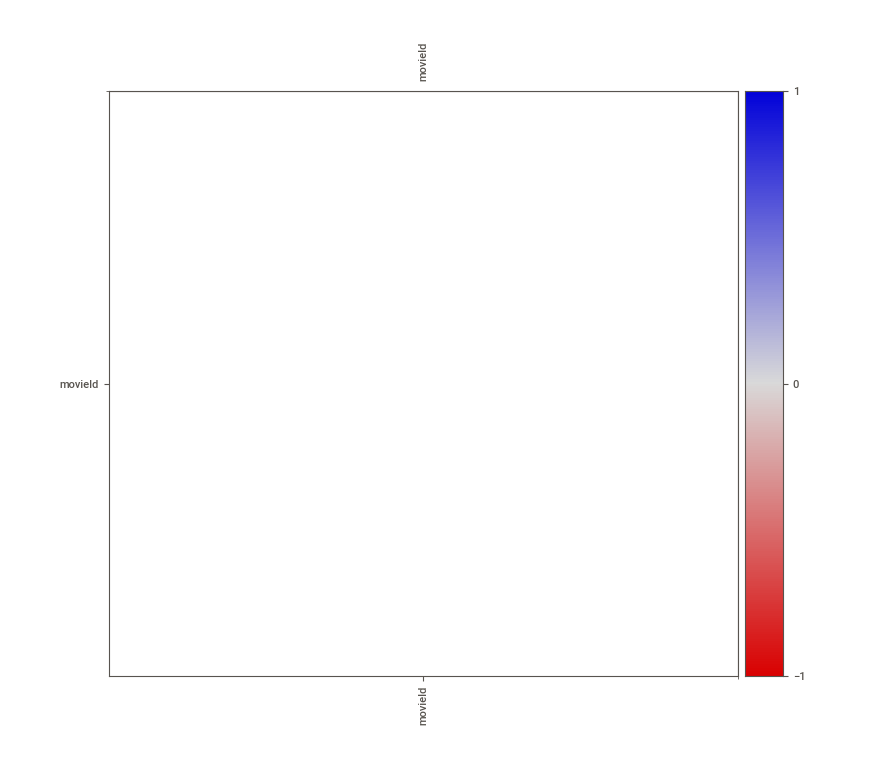
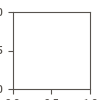

In [39]:
sv_info_df(movies)

                                             |          | [  0%]   00:00 -> (? left)


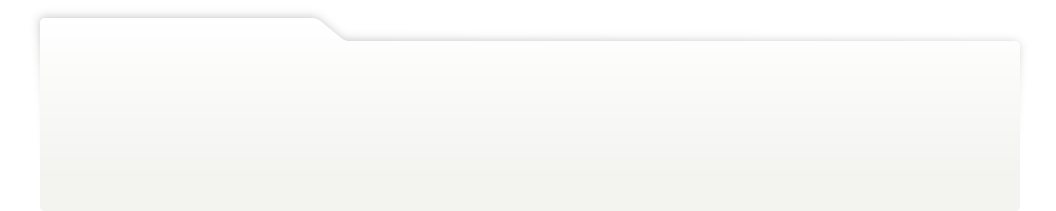
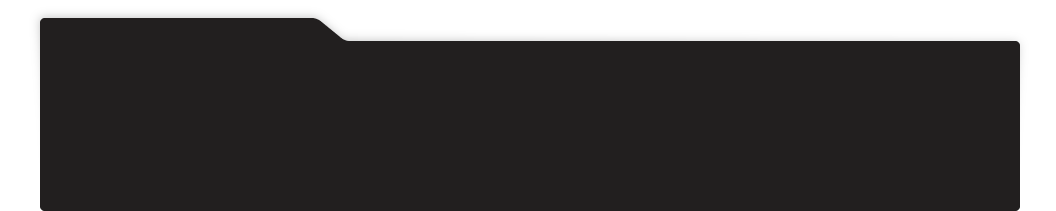
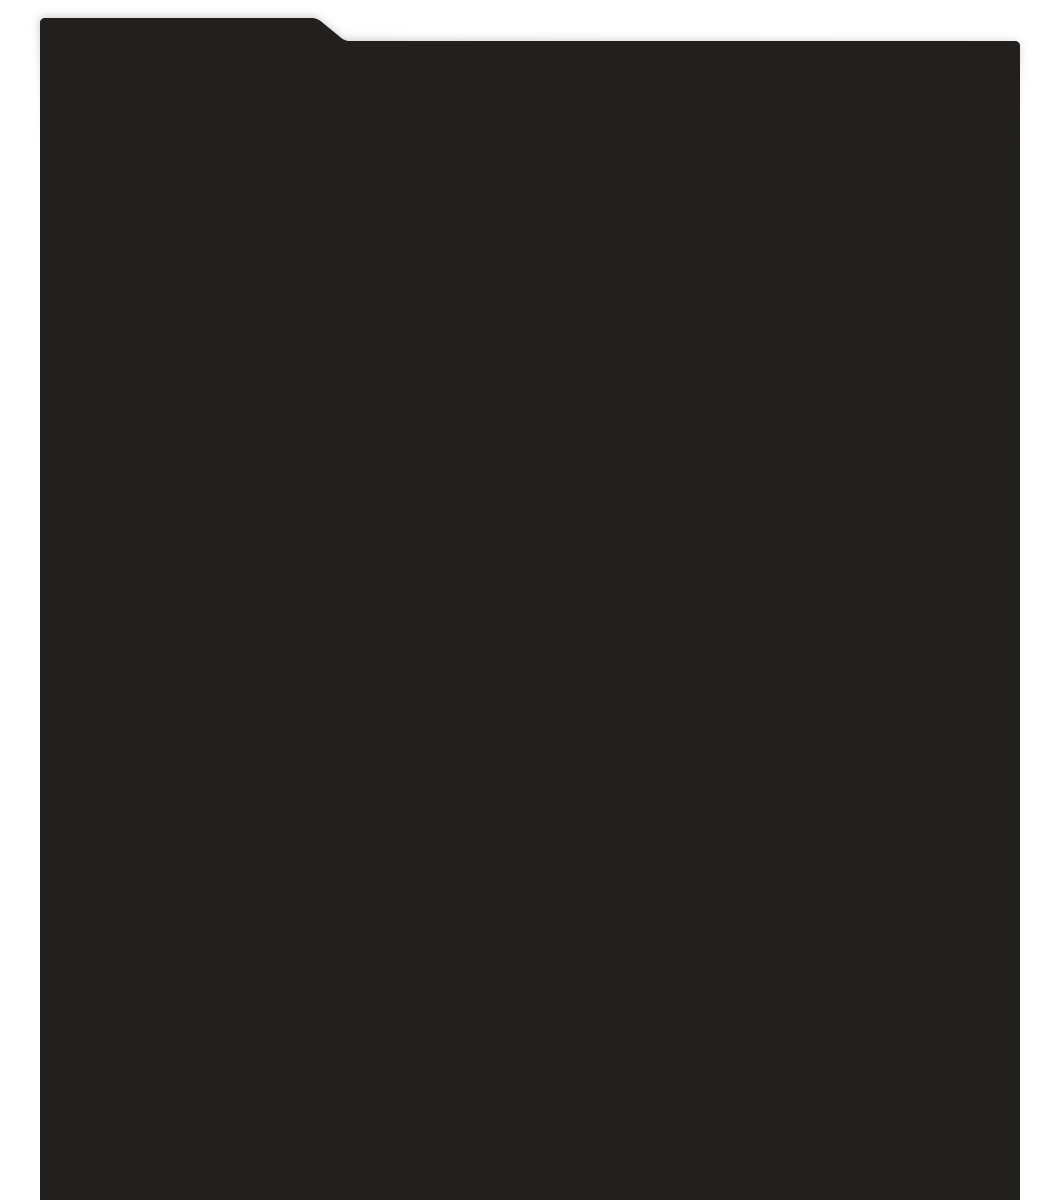
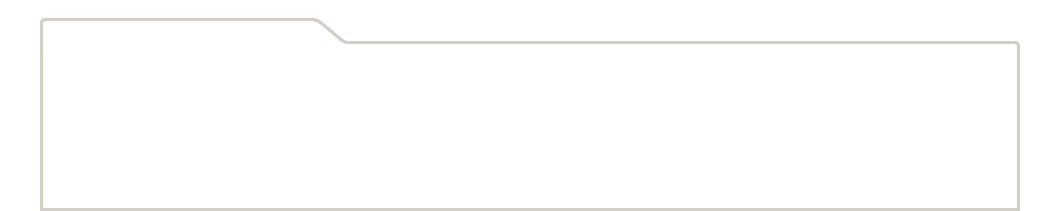
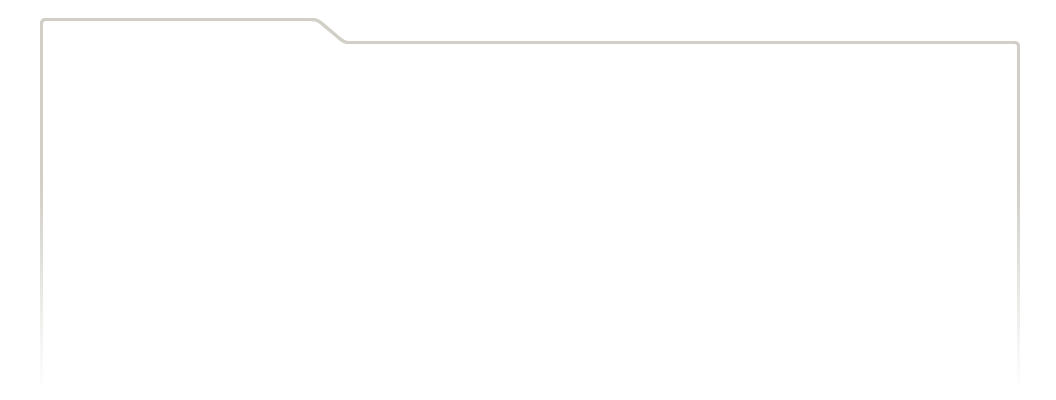
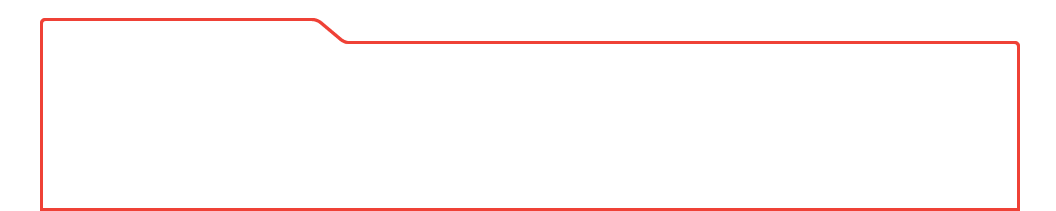
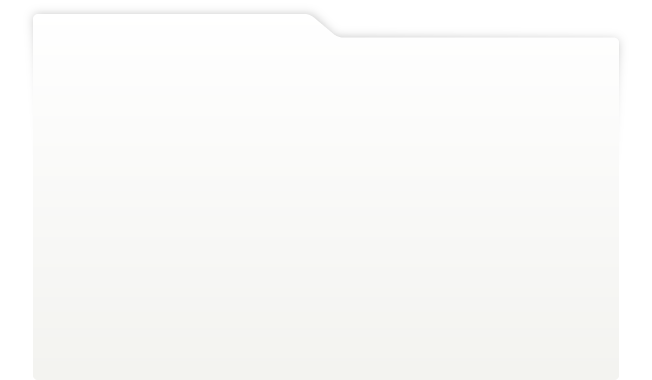
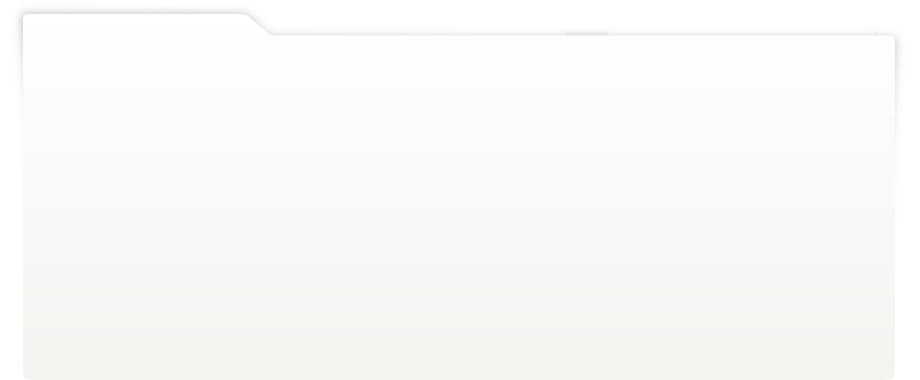
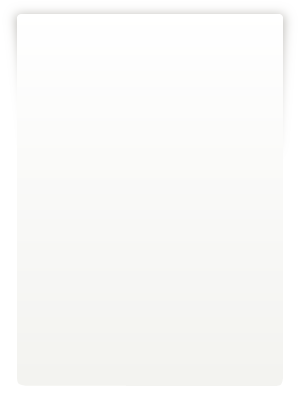
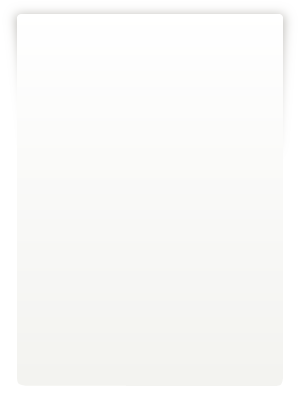
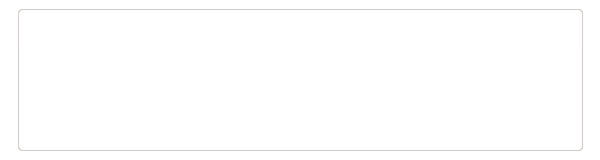
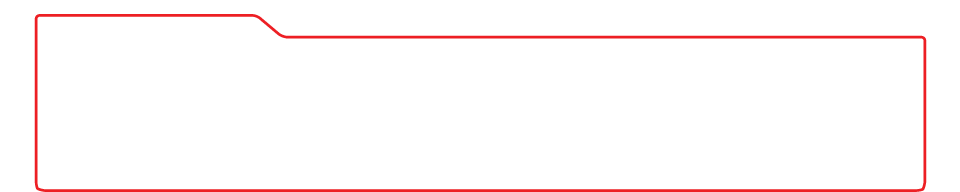
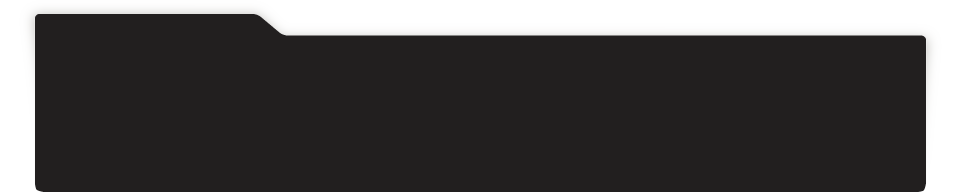
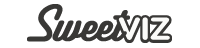
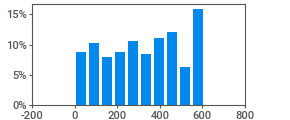
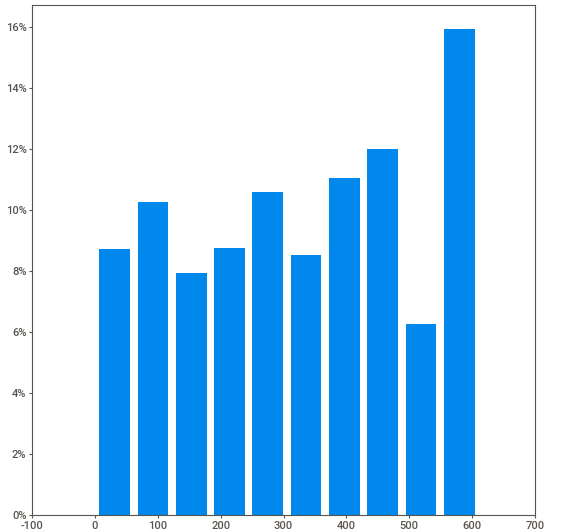
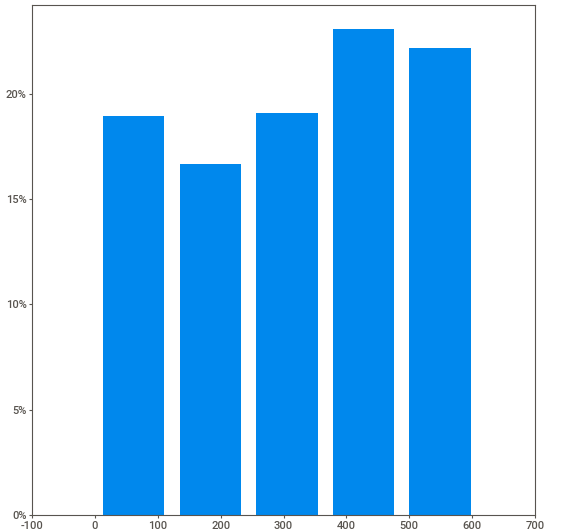
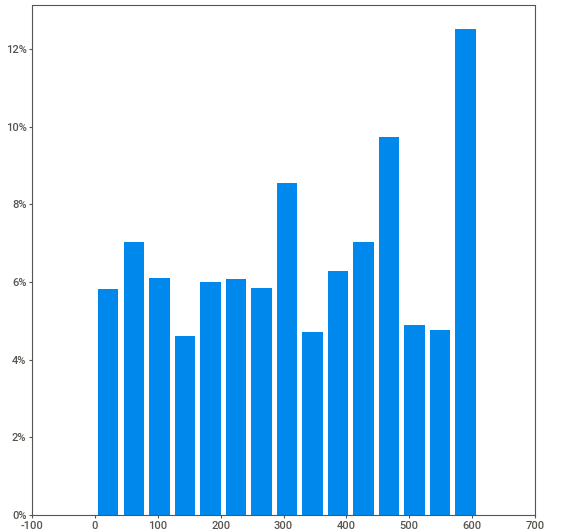
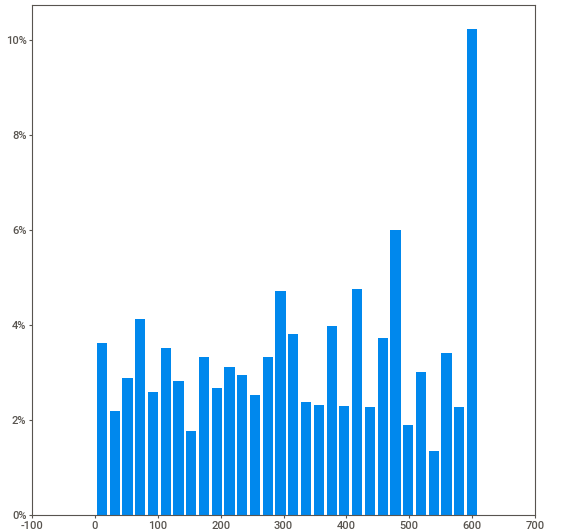
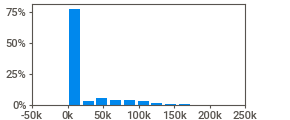
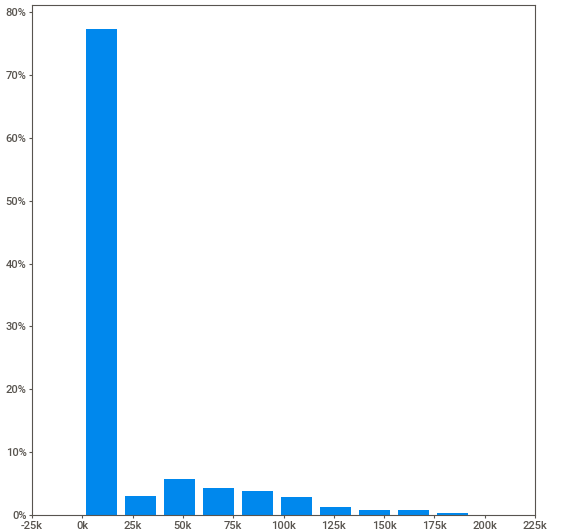
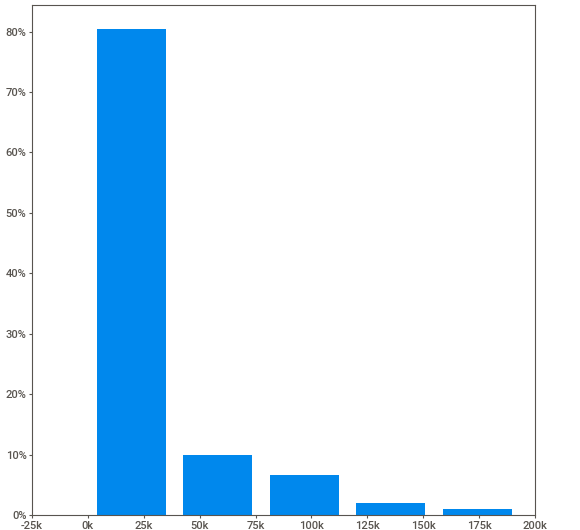
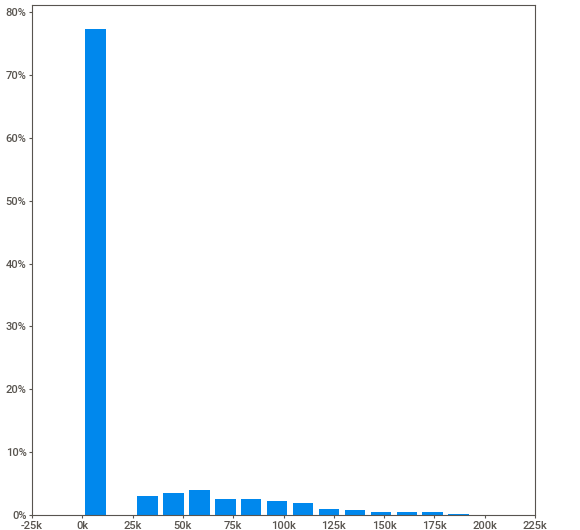
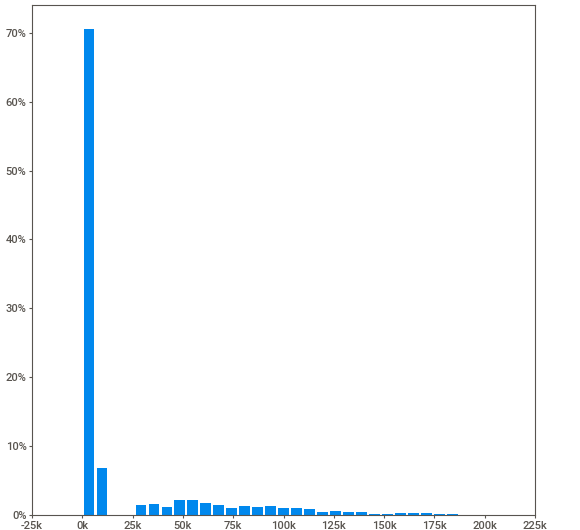
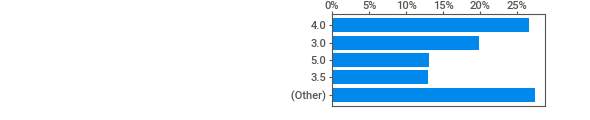
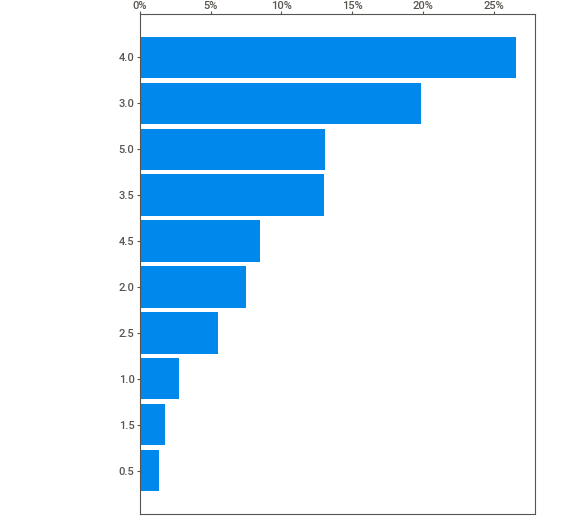
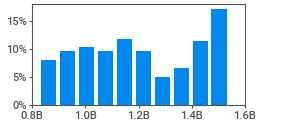
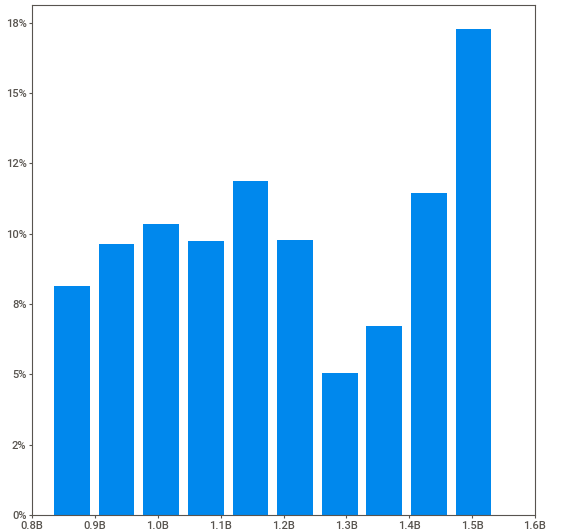
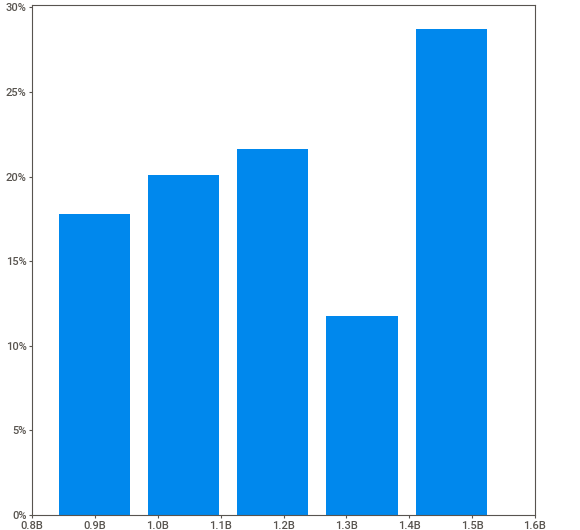
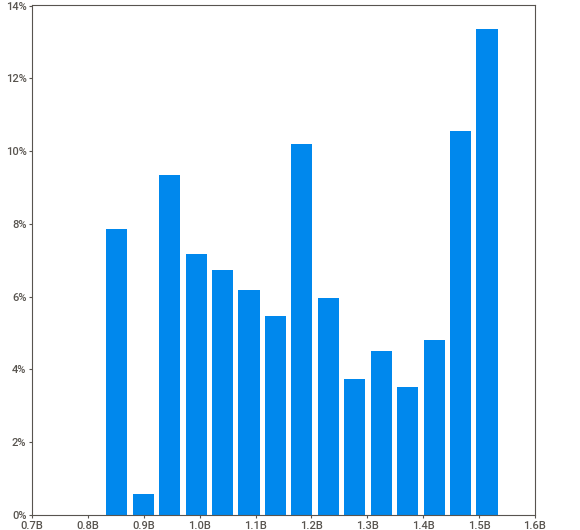
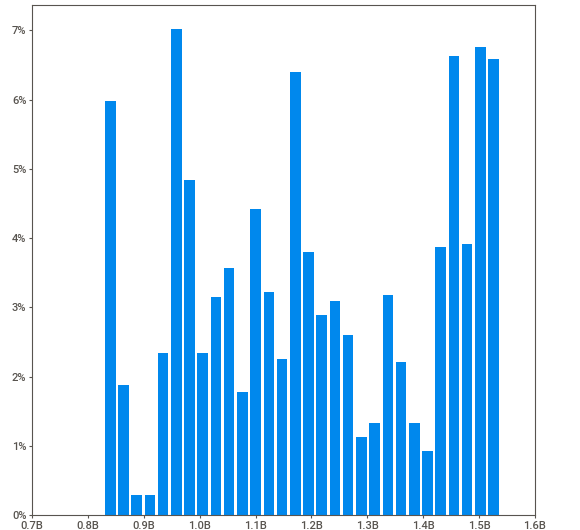
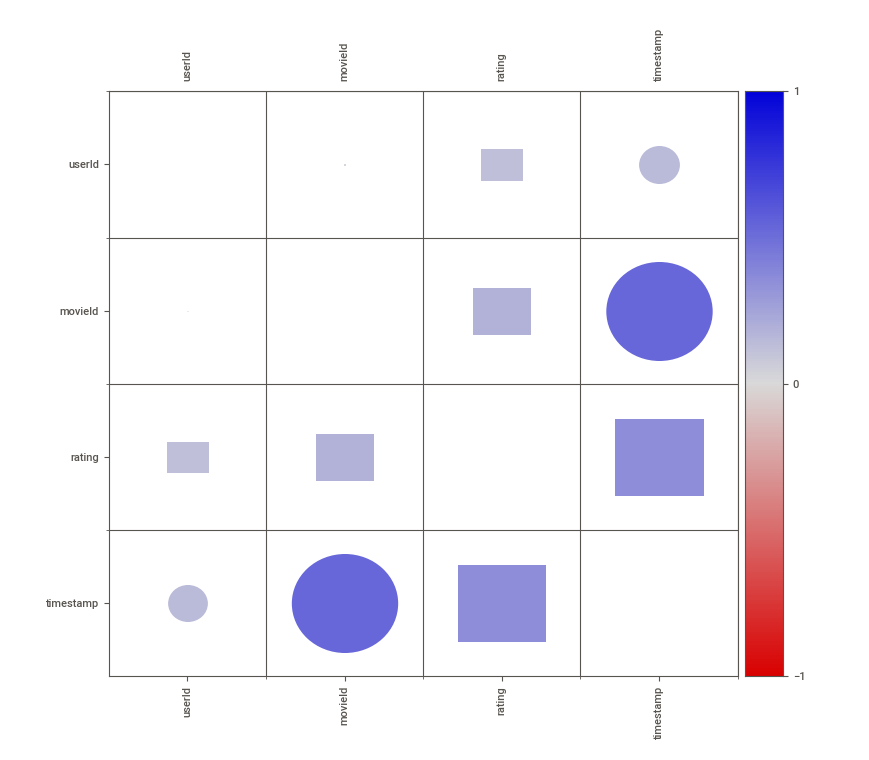
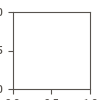

In [40]:
sv_info_df(ratings)

Для создания рекомендательной системы пара столбцов в данных не пригодятся, а именно:
- столбец `genres` в таблице `movies` - при создании коллаборативной системы используются предпочтения пользователей на основе истории просмотра и оценки.
- столбец `timestamp` в таблице `ratings` - причина для их удаления такая же, как для столбца `genres`, этот столбец не пригодиться для создания системы.

Также подкорректирую названия столбцов, чтобы они были по стандарту PEP8.

В остальном первичная подготовка с данными не требуется. Дубликатов, выбросов и пропусков нет.

In [41]:
movies = movies.drop('genres', axis=1)
movies = movies.rename(columns={
    'movieId':'movie_id'
})
movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [42]:
ratings = ratings.drop('timestamp', axis=1)
ratings = ratings.rename(columns={
    'userId':'user_id',
    'movieId':'movie_id'
})
ratings.head()

,user_id,movie_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


На  основе данных создам матрицу предподчений, где в столбцах будут номера пользователей, в строках будут номера фильмов, которые пользователи оценили, а значениями сами оценки.

In [43]:
user_rating_matrix = ratings.pivot_table(index='movie_id', columns='user_id', values='rating')
user_rating_matrix.head()


user_id,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movie_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


В матрице присутствует много пропусков, т.к. не все пользователи оценивали все фильмы, поэтому заполнил пропуски нулями.

In [44]:
user_rating_matrix = user_rating_matrix.fillna(0)
user_rating_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movie_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
#размерность матрицы как "пользователи х фильмы"
user_rating_matrix.shape

(9724, 610)

Уберу неактивных пользователей и фильмы с небольшим количеством оценок. Такие пользователи не окажут влияния на расстояния между фильмами, а малому количеству оценок довольно сложно доверять.

Для начала сгруппирую пользователей и фильмы по количеству оценок.

In [46]:
users_votes = ratings.groupby('user_id')['rating'].agg('count')
print(f'Среднее количество оценок от пользователей {users_votes.mean():.2f}')

movies_votes = ratings.groupby('movie_id')['rating'].agg('count')
print(f'Среднее количество оценок у фильмов {movies_votes.mean():.2f}')

Среднее количество оценок от пользователей 165.30
Среднее количество оценок у фильмов 10.37


Теперь создам фильтр для отвеивания неактивных пользователей и не очень популярных фильмов.

In [47]:
user_filtred = users_votes[users_votes > 165].index
movie_filtred = movies_votes[movies_votes > 10].index

In [48]:
user_rating_matrix = user_rating_matrix.reindex(columns=user_filtred)
user_rating_matrix = user_rating_matrix.reindex(index=movie_filtred)
print(user_rating_matrix.shape)
user_rating_matrix.head()

(2121, 157)


user_id,1,4,6,18,19,20,21,28,41,42,...,596,597,599,600,603,605,606,607,608,610
movie_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,3.5,4.0,0.0,3.5,0.0,0.0,0.0,...,4.0,4.0,3.0,2.5,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,...,0.0,0.0,2.5,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,4.0,0.0,0.0,0.0,3.5,0.0,0.0,...,0.0,3.0,4.5,0.0,4.0,0.0,0.0,0.0,0.0,5.0


В матрице очень много нулей. Такая матрица называется разреженной. Также, одновременно в матрице очень много столбцов, такие данные называют данные с высокой размерностью. В таком формате алгоритм будет долго обсчитывать расстояния между фильмами.

Для упрощения вычислений можно преобразовать данные в формат сжатого хранения строкой (csr).

In [49]:
csr_data = csr_matrix(user_rating_matrix.values)

В таком формате в каждой строке сначала записывается номер строки и столбца ненулевого значения, а затем само это значение.

Осталось только сбросить индекс для удобства поиска рекомендованных фильмов.

In [50]:
user_rating_matrix = user_rating_matrix.rename_axis(None, axis = 1).reset_index()
user_rating_matrix.head()

,movie_id,1,4,6,18,19,20,21,28,41,...,596,597,599,600,603,605,606,607,608,610
0,1,4.0,0.0,0.0,3.5,4.0,0.0,3.5,0.0,0.0,...,4.0,4.0,3.0,2.5,4.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,3.0,3.0,3.0,3.5,0.0,0.0,...,0.0,0.0,2.5,4.0,0.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,4.0,0.0,0.0,0.0,3.5,0.0,...,0.0,3.0,4.5,0.0,4.0,0.0,0.0,0.0,0.0,5.0


**Вывод:**

Данные подготовленны, и можно начинать обучение модели.

## Обучение модели

Для обучения модели буду использовать алгоритм k-ближайших соседей.

Для цели достаточно измерить расстояние между объектами. В этом поможет класс машинного обучения без учителя NearestNeighbors.

In [51]:
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors = 20, n_jobs = -1)

knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

Гиперпараметры модели:

- `metric = 'cosine'`: способ измерения расстояния косинусное сходство;
- `algorithm = 'brute'`: поиск решение методом полного перебора. Пространство решений позволяет перебрать все варианты;
- `n_neighbors = 20`: по скольким соседям ведется обучение.

**Вывод:**

Модель обучена и можно начать искать рекомендации.

## Поиск рекомендаций

Для примера подберу 10 рекомендуемых фильмов для фильма "Назад в Будущее".

In [52]:
recommendations = 10
search_word = 'Back to the Future'

In [53]:
movie_search = movies[movies['title'].str.contains(search_word)]
movie_search

,movie_id,title
969,1270,Back to the Future (1985)
1486,2011,Back to the Future Part II (1989)
1487,2012,Back to the Future Part III (1990)
8163,102666,Ivan Vasilievich: Back to the Future (Ivan Vas...


In [54]:
# вариантов может быть несколько, для простоты всегда будем брать первый вариант
# через iloc[0] мы берем первую строку столбца ['movieId']
movie_id = movie_search.iloc[0]['movie_id']
 
# далее по индексу фильма в датасете movies найдем соответствующий индекс
# в матрице предпочтений
movie_id = user_rating_matrix[user_rating_matrix['movie_id'] == movie_id].index[0]
movie_id

504

In [55]:
#помощью метода .kneighbors() найдем индексы ближайших соседей.

distances, indices = knn.kneighbors(csr_data[movie_id], n_neighbors = recommendations + 1)

In [56]:
# уберем лишние измерения через squeeze() и преобразуем массивы в списки с помощью tolist()
indices_list = indices.squeeze().tolist()
distances_list = distances.squeeze().tolist()
 
# далее с помощью функций zip и list преобразуем наши списки
indices_distances = list(zip(indices_list, distances_list))
 
# в набор кортежей (tuple)
print(type(indices_distances[0]))
 
# и посмотрим на первые три пары/кортежа
print(indices_distances[:3])

<class 'tuple'>
[(504, 3.3306690738754696e-16), (454, 0.18516232748659778), (124, 0.19408397332645033)]


In [57]:

# остается отсортировать список по расстояниям через key = lambda x: x[1] (то есть по второму элементу)
# в возрастающем порядке reverse = False
indices_distances_sorted = sorted(indices_distances, key = lambda x: x[1], reverse = False)
 
# и убрать первый элемент с индексом 901 (потому что это и есть заданный фильм)
indices_distances_sorted = indices_distances_sorted[1:]
indices_distances_sorted

[(454, 0.18516232748659778),
 (124, 0.19408397332645033),
 (169, 0.19666333482935183),
 (444, 0.2030141151242969),
 (521, 0.2046971045169821),
 (442, 0.2074759779236729),
 (901, 0.21612584144910452),
 (500, 0.22705279996266137),
 (941, 0.2342139490371703),
 (217, 0.23799275550191157)]

In [58]:

# создаем пустой список, в который будем помещать название фильма и расстояние до него
recom_list = []
 
# теперь в цикле будем поочередно проходить по кортежам
for ind_dist in indices_distances_sorted:
 
    # искать movieId в матрице предпочтений
    matrix_movie_id = user_rating_matrix.iloc[ind_dist[0]]['movie_id']
 
    # выяснять индекс этого фильма в датафрейме movies
    id = movies[movies['movie_id'] == matrix_movie_id].index
 
    # брать название фильма и расстояние до него
    title = movies.iloc[id]['title'].values[0]
    dist = ind_dist[1]
 
    # помещать каждую пару в словарь
    # который, в свою очередь, станет элементом списка recom_list
    recom_list.append({'Title' : title, 'Distance' : dist})

In [59]:
recom_df = pd.DataFrame(recom_list, index = range(1, recommendations + 1))
recom_df

,Title,Distance
1,Star Wars: Episode VI - Return of the Jedi (1983),0.185162
2,Star Wars: Episode IV - A New Hope (1977),0.194084
3,Forrest Gump (1994),0.196663
4,Raiders of the Lost Ark (Indiana Jones and the...,0.203014
5,Indiana Jones and the Last Crusade (1989),0.204697
6,Star Wars: Episode V - The Empire Strikes Back...,0.207476
7,"Matrix, The (1999)",0.216126
8,Groundhog Day (1993),0.227053
9,Ghostbusters (a.k.a. Ghost Busters) (1984),0.234214
10,Jurassic Park (1993),0.237993


## Вывод

Для онлайн-кинотеатра была обучена модель машинного обучения для рекомендательной системы с помощью метода **коллаборативной системы**.